In [1]:
import numpy as np
from scipy import io, signal, fft, interpolate
from scipy.signal import windows, detrend
from scipy.stats import zscore
import ipywidgets as widgets
from matplotlib import pyplot as plt
from matplotlib import cm
from matplotlib import gridspec

cmap_hot = cm.get_cmap('hot')

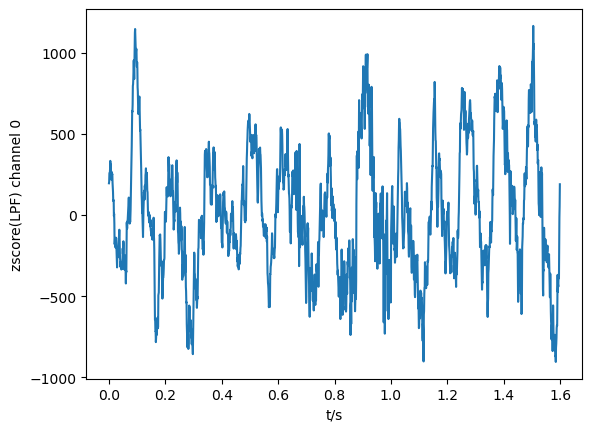

In [3]:
# load the data
# Data:  16 channels of hippocampal LFP time series from a file lfp_1shank.mat.
# Matrix lfps (1250Hz sampling rate samples x 16 channels) 
lfps = io.loadmat('../data/ws_data_1shank.mat')['lfps'] # array of LFP data
lfps = lfps.astype(np.int32)
fs = 1250 # sampling frequency
dt = 1/fs
Nt = 2000
channel = 0
t = np.arange(Nt)*dt
y = lfps[:Nt,channel].astype(np.int32)
plt.plot(t, y)
plt.xlabel('t/s')
plt.ylabel('zscore(LPF) channel %d'%channel)
plt.show()

In [4]:
def DFT(y):
    N = len(y) # number of data points : dimensionality
    t = np.arange(N)
    f = np.linspace(0, 1, N)
    a = np.zeros_like(y, dtype=complex)
    for i in range(N): 
        a[i] = np.sum(y * np.exp(-1j*2*np.pi*f[i]*t))

    return a

def iDFT(a):
    N = len(a)
    t = np.arange(N)
    f = np.linspace(0, 1, N)
    y = np.zeros_like(a, dtype=complex)
    for i in range(N):
        y[i] = np.sum(a * np.exp(1j*2*np.pi*f*t[i]))

    return y, f

def Periodogram(y, method='autocorrelation'):
    if method=='direct':
        a = np.fft.fft(y)
        p = np.abs(a)**2
        
    elif method=='autocorrelation':
        p = np.abs(np.fft.fft(np.convolve(y, y[::-1], mode='same')))
    
    f = np.linspace(0, 1, len(p))
    return p/len(y), f

# Exercise 1

## Periodogram

In [5]:
p_auto, f_auto = Periodogram(y, method='autocorrelation')
p, f = Periodogram(y, method='direct')

# np.sum(p_auto) == np.mean(p) == np.sum(y**2)

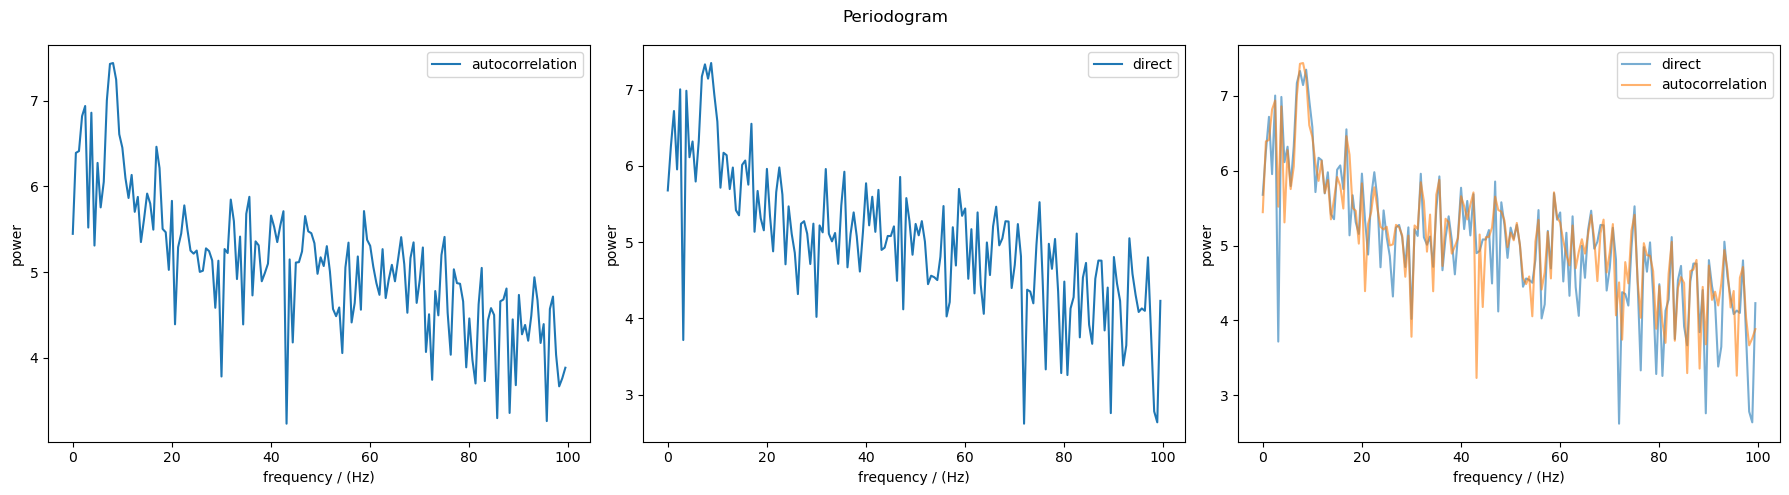

In [6]:
%matplotlib inline
f_max = int(100/1250 * len(f))
f_max_auto = int(100/1250 * len(f_auto))

fig, ax = plt.subplots(1,3,figsize=(18,5))
ax[0].plot(f_auto[:f_max_auto]*fs, np.log10(p_auto[:f_max_auto]), label='autocorrelation')
ax[1].plot(f[:f_max]*fs, np.log10(p[:f_max]), label='direct')
ax[2].plot(f[:f_max]*fs, np.log10(p[:f_max]), label='direct', alpha=0.6)
ax[2].plot(f_auto[:f_max_auto]*fs, np.log10(p_auto[:f_max_auto]), label='autocorrelation', alpha=0.6)


for i in range(3):
    ax[i].legend()  
    ax[i].set_xlabel('frequency / (Hz)')
    ax[i].set_ylabel('power')

fig.suptitle('Periodogram')
plt.tight_layout()
plt.show()

## window-size effect on periodogram

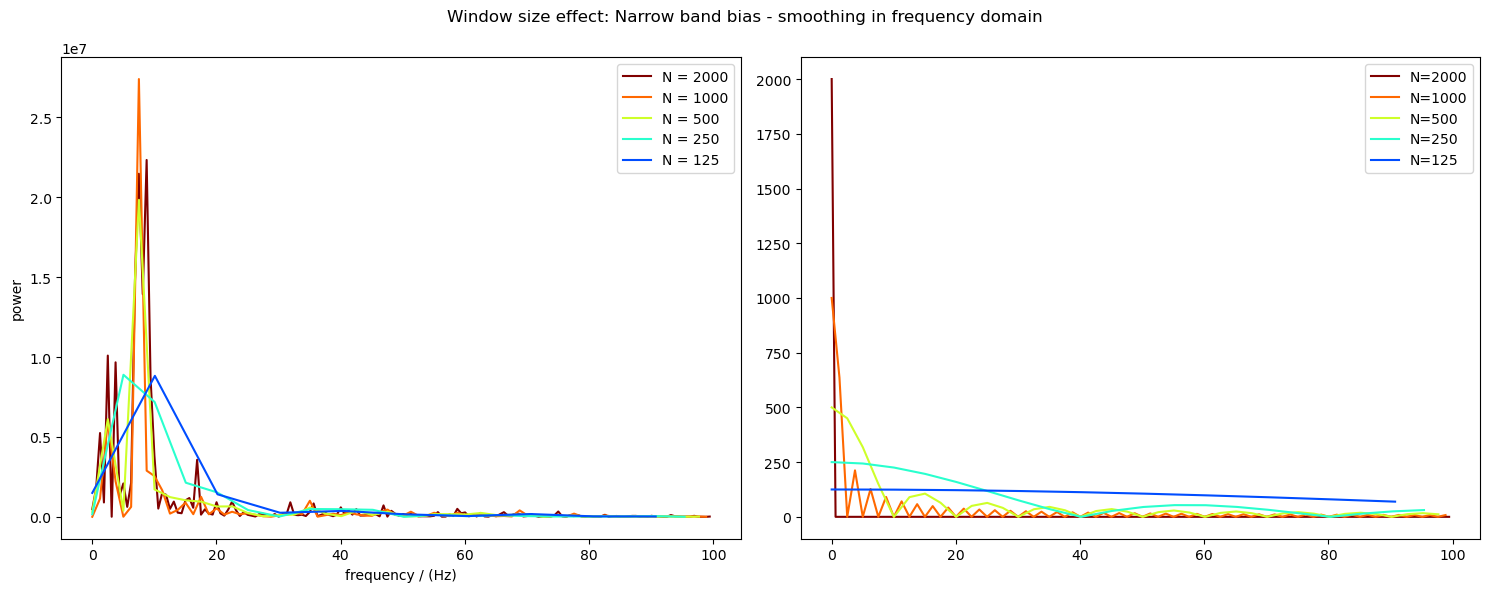

In [7]:
fig, ax = plt.subplots(1, 2, figsize=(15,6))
Nt_list = (1/(2** np.arange(5)) * len(y)).astype(int)
cmap = cm.get_cmap('jet')

for i, Nt in enumerate(Nt_list):
    p, f = Periodogram(y[:Nt], method='direct')
    f = f*fs
    f_max = int(100/fs * Nt)
    window_fft = np.abs(np.fft.fft(np.arange(max(Nt_list))<Nt))

    ax[0].plot(f[:f_max], p[:f_max], c=cmap(1-i/len(Nt_list)), label='N = %d'%Nt)
    ax[1].plot(f[:f_max], window_fft[:f_max], c=cmap(1-i/len(Nt_list)), label='N=%d'%Nt)

ax[0].set_ylabel('power')
ax[0].set_xlabel('frequency / (Hz)')
ax[0].legend()
ax[1].legend()

fig.suptitle('Window size effect: Narrow band bias - smoothing in frequency domain')
plt.tight_layout()
plt.show()

# Welch estimate

In [8]:
def Welch_psd(x, wN, M, overlap=0.5, W=1, nfft=None, return_window=False):
    win = signal.windows.dpss(M, W)
    wT = int((1-overlap)*M)
    t0 = 0
    psd = []
    tf = (wN-1) * wT + M
    y = x[:tf]
    if nfft==None:
        nfft = M

    zeropad = False
    if nfft>M:
        zeropad = True
    
    while True:
        if t0+M > tf:
            if t0==0:
                print('wrong')
            break


        if zeropad:
            win_z = np.concatenate((win, np.zeros(nfft-M)))
            z = np.concatenate((y[t0:t0+M], np.zeros(nfft-M)))
        
        else:
            win_z = win
            z = y[t0:t0+M]

        p, f = Periodogram(win_z*z, method='direct')
        wN += 1
        t0 += wT
        psd.append(p)
    
    psd = np.array(psd) # shape (wN, len(y)) #segments, #datapoints
    
    if return_window:
        return psd, f, win

    return psd, f

In [9]:
%matplotlib inline

@widgets.interact(wN=widgets.IntSlider(5,5,50,1), M=widgets.IntSlider(50,50,500,50), w=widgets.IntSlider(1,1,20,1, description='W'),
 overlap=widgets.FloatSlider(0.5, min=0, max=0.9, step=0.1), nfft_frac=widgets.FloatSlider(0, min=0, max=2, step=0.1))

def welch_plot(wN, M, w, overlap, nfft_frac):
    fig, ax = plt.subplots(1,4,figsize=(20,5))
    psd, f, win = Welch_psd(lfps[:, 0], wN, M, overlap=overlap, W=w, nfft=int((nfft_frac+1)*M), return_window=True)
    f_max = 3*int(100/fs * M)
    for p in psd:
        ax[0].scatter(f[:f_max]*fs, p[:f_max])
    ax[0].set(xlim=[-5,100])
    ax[1].errorbar(f[:f_max]*fs, np.mean(psd[:, :f_max], axis=0), np.std(psd[:,:f_max], axis=0)/np.sqrt(len(psd)))
    ax[1].set(xlim=[-5,100])
    ax[2].plot(np.linspace(-M/2,M/2,M), win)
    ax[2].set_xlim([-500,500])
    wf, h = signal.freqz(win)
    h_nonzero = np.where(h!=0)
    ax[3].plot(wf[h_nonzero]/(2*np.pi), 20 * np.log10(np.abs(h[h_nonzero])), color='b', lw=1.)
    # ax[3].plot(np.linspace(0,1,M), 20 * np.log10(np.abs(scipy.fft.fft(win))))
    ax[3].set_xlim([0,1/2])
    # ax[3].vlines(0.3,)
    plt.show()

interactive(children=(IntSlider(value=5, description='wN', max=50, min=5), IntSlider(value=50, description='M'…

## Detrend

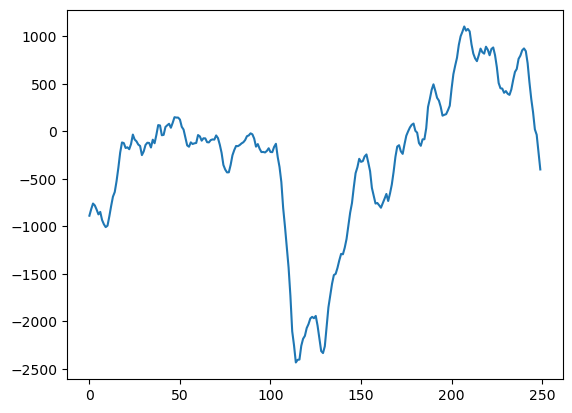

In [10]:
plt.plot(lfps[:250, 7])

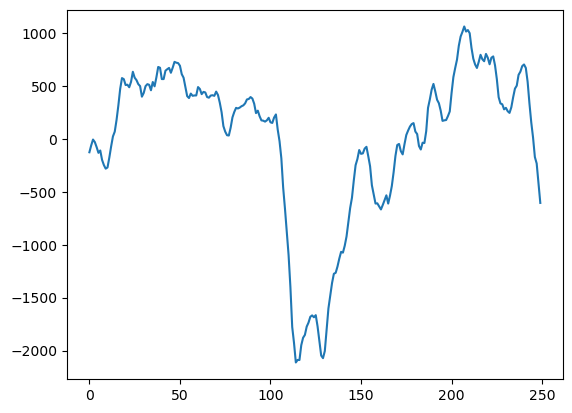

In [11]:
plt.plot(signal.detrend(lfps[:250,7]))

## Multitaper spectral estimate

In [13]:
def multitaper_psd(y, NW=2, detrend=True, K_max=None, nfft=None, return_window=False):
    """
    Returns multitaper estimate of signal y

    Parameters
    y: signal 1d numpy array
    W: half-bandwidth
    K_max: maximum number of slepian tapers. if None, K_max is set equal to 2*len(y)*W-1

    """
    if detrend:
        y = signal.detrend(y)

    t0 = 0
    psd = []
    N = len(y)

    if K_max==None:
        K_max = int(2*NW - 1)
        if not (K_max > 0 and K_max < N/2):
            print('increase resolution')
            ValueError 
            
    win = signal.windows.dpss(len(y), NW, Kmax=K_max)

    if nfft==None:
        nfft = N

    zeropad = False
    if nfft>N:
        zeropad = True

    for win_i in win:
        if zeropad:
            win_z = np.concatenate((win_i, np.zeros(nfft-N)))
            z = np.concatenate((y, np.zeros(nfft-N)))
        
        else:
            win_z = win_i
            z = y

        p, f = Periodogram(win_z*z, method='direct')
        psd.append(p)
    
    psd = np.array(psd) # shape (K_max, len(y)) #tapers, #datapoints
    
    if return_window:
        return psd, f, win    

    return psd, f    

def sliding_window(x, win_size, step):
    return np.arange(0, len(x)-win_size, step)

def spectrogram(x, win_size=2**8, step=2**5, method=lambda x:np.mean(multitaper_psd(x, NW=int(2 * len(x)/ fs))[0], axis=0),  progress_report=False):
    sliding_window_t_on = sliding_window(x, win_size, step)
    psd_spec = []
    for i, t_on in enumerate(sliding_window_t_on):
        if progress_report:
            print('%.2f'%(100*(i+1)/len(sliding_window_t_on)) + '%', end='\r')

        psd_spec.append(method(x[t_on:t_on + win_size]))

    return np.array(psd_spec).T, sliding_window_t_on+win_size/2

In [14]:
%matplotlib inline

short_seg = lfps[:fs, 0]
long_seg = lfps[:10*fs, 0]
sig = short_seg

@widgets.interact(NW=widgets.IntSlider(1,1,10,1), nfft_frac=widgets.FloatSlider(0, min=0, max=2, step=0.1))

def multitaper_plot(NW, nfft_frac):
    fig, ax = plt.subplots(1,5,figsize=(25,5))
    M = len(sig)
    # w = NW/M
    psd, f, win = multitaper_psd(sig, NW, nfft=int((nfft_frac+1)*M), return_window=True)
    f_max = 3*int(100/fs * len(sig))
    for p in psd:
        ax[0].scatter(f[:f_max]*fs, p[:f_max])
        
    ax[0].set(xlim=[-5,100], title='individual taper spectral estimate')
    ax[1].plot(f[:f_max]*fs, np.log10(np.mean(psd[:, :f_max], axis=0)))
    ax[1].set(xlim=[-5,100], title='mean taper spectral estimate')
    
    # variance:
    ax[2].plot(np.var(np.log10(psd[:, :f_max]), axis=0))
    ax[2].set(title='var(log(psd))', xlabel='f/Hz', ylim=[-2,10])

    for w_order in range(len(win)):
        ax[3].plot(np.linspace(-M/2,M/2,M), win[w_order])
        wf, h = signal.freqz(win[w_order])
        h_nonzero = np.where(h!=0)
        ax[4].plot(wf[h_nonzero]/(2*np.pi), 20 * np.log10(np.abs(h[h_nonzero])), lw=1.)

    ax[3].set(xlim=[-fs/2,fs/2], title='taper in time domain')
    ax[4].set(title='taper in frequency domain', xlim = [0,1/2])

    # ax[-1].plot(np.linspace(0,1,M), 20 * np.log10(np.abs(scipy.fft.fft(win))))
    # ax[-1].vlines(0.3,)
    plt.show()

interactive(children=(IntSlider(value=1, description='NW', max=10, min=1), FloatSlider(value=0.0, description=…

## Effect of time-frequency bandwidth (NW) on variance and resolution

### effect of the window length, zero padding and NW on resolvable spectral features in the power spectrum for theta and gamma bands.	

In [15]:
%matplotlib inline

short_seg = lfps[:fs, 0]
long_seg = lfps[:60*fs, 0]

@widgets.interact(N=widgets.IntSlider(100,100,1000,50), NW=widgets.IntSlider(2,1,20,1), nfft_frac=widgets.FloatSlider(0, min=0, max=2, step=0.1))
def multitaper_plot(N, NW, nfft_frac):
    # w = NW/N
    fig, ax = plt.subplots(1,5,figsize=(25,5))
    psd, f, win = multitaper_psd(long_seg[:N], NW, nfft=int((nfft_frac+1)*N), return_window=True)
    f_max = 3*int(100/fs * len(long_seg[:N]))
    for p in psd:
        ax[0].scatter(f[:f_max]*fs, p[:f_max])
        
    ax[0].set(xlim=[-5,100])
    # ax[1].errorbar(f[:f_max]*fs, np.mean(psd[:, :f_max], axis=0), np.std(psd[:,:f_max], axis=0)/np.sqrt(len(psd)))
    ax[1].plot(f[:f_max]*fs, np.log10(np.mean(psd[:, :f_max], axis=0)))
    ax[1].set(xlim=[-5,100])
    ax[1].set_title('psd')

    if len(win)>1:
        ax[2].plot(f[:f_max]*fs, np.log10(np.var(psd[:,:f_max], axis=0)))
        ax[2].set(xlim=[-5,100], title='log variance', ylim=[-7,10])

    for w_order in range(len(win)):
        ax[3].plot(np.linspace(-N/2,N/2,N), win[w_order])
        ax[3].set_xlim([-fs/2,fs/2])
        wf, h = signal.freqz(win[w_order])
        h_nonzero = np.where(h!=0)
        ax[4].semilogx(wf[h_nonzero]/(2*np.pi), 20 * np.log10(np.abs(h[h_nonzero])), lw=1.)
    # ax[3].plot(np.linspace(0,1,M), 20 * np.log10(np.abs(scipy.fft.fft(win))))
    ax[4].set_xlim([0.001,0.5])
    # ax[3].vlines(0.3,)
    plt.show()

interactive(children=(IntSlider(value=100, description='N', max=1000, min=100, step=50), IntSlider(value=2, de…

## Spectral content varies with depth

In [16]:
# high pass filter

sos = signal.butter(10, 15, 'hp', fs=1000, output='sos')
filtered = signal.sosfilt(sos, lfps)

In [17]:
%matplotlib inline

@widgets.interact(nW=widgets.IntSlider(10,5,20,1, description='num segments'), NW=widgets.IntSlider(2,1,10,1), M=widgets.IntSlider(5*fs,fs//2,10*fs,fs//2))

def multitaper_plot(nW, NW, M):
    Nchannel = 16
    data = lfps[:nW*M].transpose(1,0).reshape(Nchannel, nW, M)
    f_max = int(100/fs * M)
    K_max = int(2*NW-1)
    multitaper_estimate = np.ndarray((Nchannel, nW, K_max, f_max))
    for ichannel in range(Nchannel):
        for iW in range(nW):
            psd, f = multitaper_psd(data[ichannel, iW], NW=NW)
            multitaper_estimate[ichannel, iW] =  psd[:, :f_max]

    # np.std(psd[:,:f_max], axis=0)/np.sqrt(len(psd))

    Nsample = K_max * nW
    channel_psd_sample = multitaper_estimate.transpose(0,3,1,2).reshape(Nchannel, f_max, Nsample)
    channel_psd_mean = np.mean(channel_psd_sample, axis=2)
    # channel_psd_sem = np.std(channel_psd_sample, axis=2)/np.sqrt(Nsample)

    fig, ax = plt.subplots(2,1, figsize=(7,10))
    ax[0].imshow(np.log10(channel_psd_mean), aspect='auto', extent=[0, 99, 15, 0])
    ax[0].set(xlabel='f/Hz', ylabel='channel')

    # for ichannel in range(Nchannel):
    #     im = ax[1].plot(f[:f_max]*fs, channel_psd_mean[ichannel], color=cmap_hot(ichannel/Nchannel), alpha=0.5, label=ichannel)
    f_lowerbound = int(5/fs * len(f))
    f_argmax = np.argmax(channel_psd_mean[:, f_lowerbound:], axis=1) + f_lowerbound
    ax[1].plot(np.arange(Nchannel), f[f_argmax]*fs, label='argmax spectral power (Hz)')
    ax[1].plot(np.arange(Nchannel), zscore(np.diagonal(channel_psd_mean[:, f_argmax])), label='max spectral power (normalized)')
    ax[1].set_xlabel('channel')
    ax[1].legend()
    plt.show()

interactive(children=(IntSlider(value=10, description='num segments', max=20, min=5), IntSlider(value=2, descr…

# Exercise 2

In [18]:
def multitaper_psd(y, NW=2, detrend=True, K_max=None, nfft=None, return_window=False):
    """
    Returns multitaper estimate of signal y

    Parameters
    y: signal 1d numpy array
    W: half-bandwidth
    K_max: maximum number of slepian tapers. if None, K_max is set equal to 2*len(y)*W-1

    """
    if detrend:
        y = signal.detrend(y)

    t0 = 0
    psd = []
    N = len(y)

    if K_max==None:
        K_max = int(2*NW - 1)
        if not (K_max > 0 and K_max < N/2):
            print('increase resolution')
            ValueError 
            
    win = signal.windows.dpss(len(y), NW, Kmax=K_max)

    if nfft==None:
        nfft = N

    zeropad = False
    if nfft>N:
        zeropad = True

    for win_i in win:
        if zeropad:
            win_z = np.concatenate((win_i, np.zeros(nfft-N)))
            z = np.concatenate((y, np.zeros(nfft-N)))
        
        else:
            win_z = win_i
            z = y

        p, f = Periodogram(win_z*z, method='direct')
        psd.append(p)
    
    psd = np.array(psd) # shape (K_max, len(y)) #tapers, #datapoints
    
    if return_window:
        return psd, f, win    

    return psd, f    

def sliding_window(x, win_size, step):
    return np.arange(0, len(x)-win_size, step)

def spectrogram(x, win_size=2**8, step=2**5, method=lambda x:np.mean(multitaper_psd(x, NW=int(2 * len(x)/ fs))[0], axis=0),  progress_report=False):
    sliding_window_t_on = sliding_window(x, win_size, step)
    psd_spec = []
    for i, t_on in enumerate(sliding_window_t_on):
        if progress_report:
            print('%.2f'%(100*(i+1)/len(sliding_window_t_on)) + '%', end='\r')

        psd_spec.append(method(x[t_on:t_on + win_size]))

    return np.array(psd_spec).T, sliding_window_t_on+win_size/2

In [19]:
%matplotlib inline
# win_size = 2**12
# # NWdf = 1 # half bandwidht in Hz
# # NW = NWdf * win_size / f_sampling
# NW = 1
f_sampling = 1000
step = 2**8
@widgets.interact(f_sine = widgets.IntSlider(10, 5, 100, 5), win_size=widgets.IntSlider(1000, 100, 5000, 100), NW=widgets.FloatSlider(2.5, min=1, max=5, step=0.5), win_idx=widgets.FloatSlider(0, min=0, max=1, step=0.01))

def plot_spec(f_sine, win_size, NW, win_idx):
    fig, ax = plt.subplots(1, 3, figsize=(18,6))
    time = np.arange(0,30,1/f_sampling)
    x = np.sin(2 * np.pi * f_sine * time)
    method = lambda x:np.mean(multitaper_psd(x, NW)[0], axis=0)
    x_spec, t_spec = spectrogram(x, win_size=win_size, step=step, method=method)
    f_max = int(100/f_sampling * x_spec.shape[0])
    f = np.linspace(0,1,x_spec.shape[0])*f_sampling
    win_id = int(win_idx*x_spec.shape[1])
    disp_time = t_spec[win_id]/f_sampling

    ax[1].loglog(f[:f_max], x_spec[:f_max, win_id], '*', label='t = %.1f'%disp_time+'s')
    ax[1].set(xlabel='f / Hz', xlim=[1,100])
    # ax[1].set_ylim([0,0.05])
    ax[1].legend()
    ax[0].plot(time[:1*f_sampling], x[:1*f_sampling])
    ax[0].set(xlabel='t / s')
    ax[2].imshow(np.log10(x_spec[:f_max, :]), aspect='auto', extent=[t_spec[0]/f_sampling, t_spec[-1]/f_sampling, 100, 0])
    ax[2].set(xlabel='t / s', ylabel='f / Hz')
    ax[2].invert_yaxis()
    ax[2].set_title('step = %d'%(1000*step/f_sampling) + 'ms, win_size = %.2f'%(win_size/f_sampling) + 's, NW = %.2f'%NW)
    ax[2].vlines(disp_time, 0, 100, 'r')
    fig.suptitle('multitaper estimate of power spectrum')
    plt.tight_layout()

interactive(children=(IntSlider(value=10, description='f_sine', min=5, step=5), IntSlider(value=1000, descript…

In [20]:
ichannel = 6
Ts = 30 # in s duration
t0 = 0 # in s start time < 362
N = fs*Ts
x = lfps[t0:N, ichannel]

In [21]:
win_size = 2**11
step = 2**5
# NWdf = 1 # half bandwidht in Hz
# NW = NWdf * win_size / fs
NW = 2.5
method = lambda x:np.mean(multitaper_psd(x, NW)[0], axis=0)
x_spec, t_spec = spectrogram(x, win_size=win_size, step=step, method=method, progress_report=True)

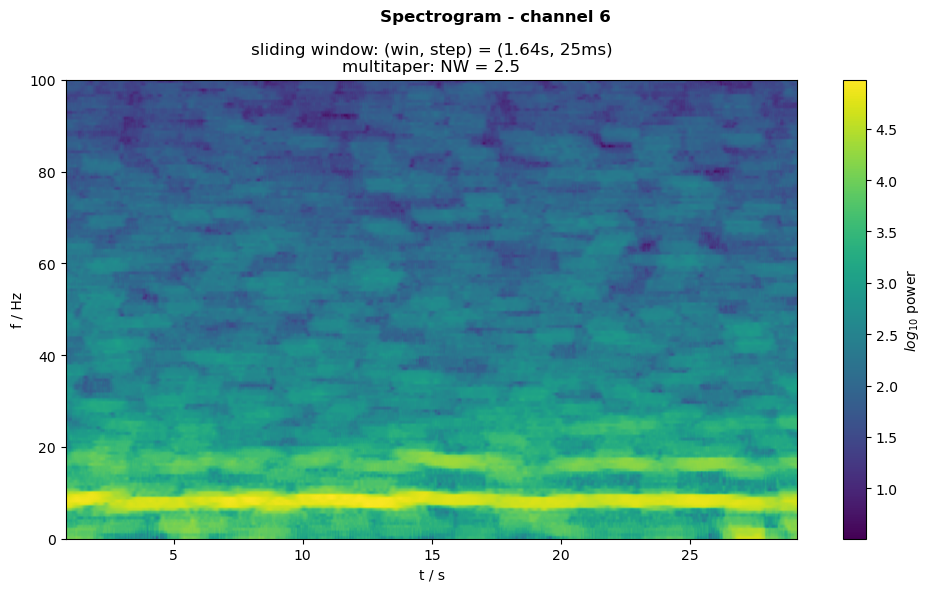

In [22]:
f_max = int(100/fs * win_size)
fig = plt.figure(figsize=(10,6))
ax = plt.subplot(1,1,1)
im = ax.imshow(np.log10(x_spec[:f_max, :]), aspect='auto', extent=[t_spec[0]/fs, t_spec[-1]/fs, 100, 0])
ax.set_xlabel('t / s')
ax.set_ylabel('f / Hz')
ax.invert_yaxis()
ax.set_title('sliding window: (win, step) = (%.2f'%(win_size/fs) +'s, %d'%(1000*step/fs) +'ms)\n''multitaper: NW = %.1f'%NW)
fig.colorbar(im, label='$log_{10}$ power')
fig.suptitle('Spectrogram - channel %d'%ichannel, weight='bold')
plt.tight_layout()
plt.show()

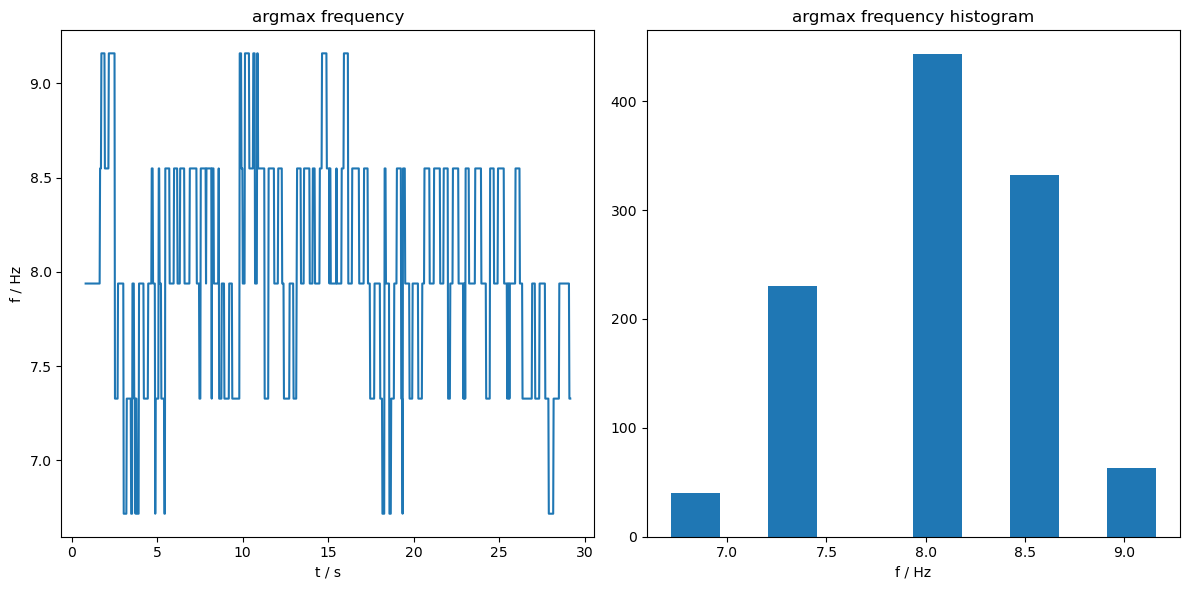

In [23]:
fig, ax = plt.subplots(1,2,figsize=(12,6))
f = np.linspace(0, fs, x_spec.shape[0])
f_argmax_spec = f[np.argmax(x_spec[:int(x_spec.shape[0]/2)], axis=0)]
ax[0].plot(t_spec/fs, f_argmax_spec)
ax[0].set(xlabel='t / s', ylabel='f / Hz', title='argmax frequency')
ax[1].hist(f_argmax_spec)
ax[1].set(xlabel='f / Hz', title='argmax frequency histogram')
plt.tight_layout()
plt.show()

---

# Wavelet transform

/home/arash/anaconda3/envs/LFP-Grid/lib/python3.10/site-packages/pywt/_functions.py:143: FutureWarning: Wavelets from the family cmor, without parameters specified in the name are deprecated. The name should takethe form cmorB-C where B and C are floats representing the bandwidth frequency and center frequency, respectively (example: cmor1.5-1.0).
  wavelet = DiscreteContinuousWavelet(wavelet)
/home/arash/anaconda3/envs/LFP-Grid/lib/python3.10/site-packages/pywt/_cwt.py:117: FutureWarning: Wavelets from the family cmor, without parameters specified in the name are deprecated. The name should takethe form cmorB-C where B and C are floats representing the bandwidth frequency and center frequency, respectively (example: cmor1.5-1.0).
  wavelet = DiscreteContinuousWavelet(wavelet)


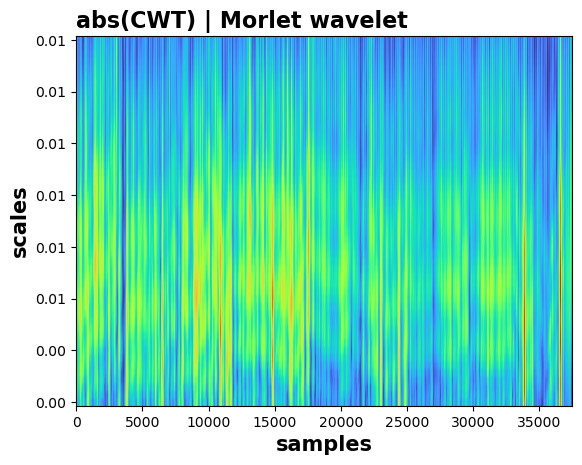

In [27]:
from ssqueezepy import cwt
from ssqueezepy.visuals import plot, imshow
import pywt
convert = lambda x : pywt.scale2frequency('cmor', x)

f0 = 5
f1 = 15
s0 = convert(f1/fs)
s1 = convert(f0/fs)
sm = convert(8/fs)
scales = 10**np.linspace(np.log10(s0), np.log10(s1), 50)
# scales = np.arange(sm-40, sm+40, 1)
x = lfps[:30*fs, 7].astype(np.int32)

Wx, scales = pywt.cwt(x, wavelet='cmor', scales=scales)
imshow(Wx, yticks=scales, abs=1,
       title="abs(CWT) | Morlet wavelet",
       ylabel="scales", xlabel="samples")

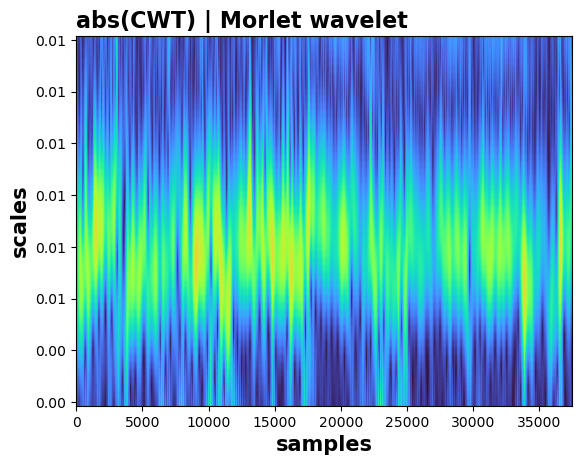

In [28]:
from ssqueezepy import cwt
from ssqueezepy.visuals import plot, imshow
import pywt
convert = lambda x : pywt.scale2frequency('morl', x)

f0 = 5
f1 = 15
s0 = convert(f1/fs)
s1 = convert(f0/fs)
sm = convert(8/fs)
scales = 10**np.linspace(np.log10(s0), np.log10(s1), 50)
# scales = np.arange(sm-40, sm+40, 1)
x = lfps[:30*fs, 7].astype(np.int32)

Wx, scales = pywt.cwt(x, wavelet='morl', scales=scales)
imshow(Wx, yticks=scales, abs=1,
       title="abs(CWT) | Morlet wavelet",
       ylabel="scales", xlabel="samples")

/tmp/ipykernel_289219/4127207435.py:4: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set(yticklabels=map(lambda x:'%.2f'%x,(convert(yticks)*fs)), ylabel='~ f / Hz (converted from scales)')


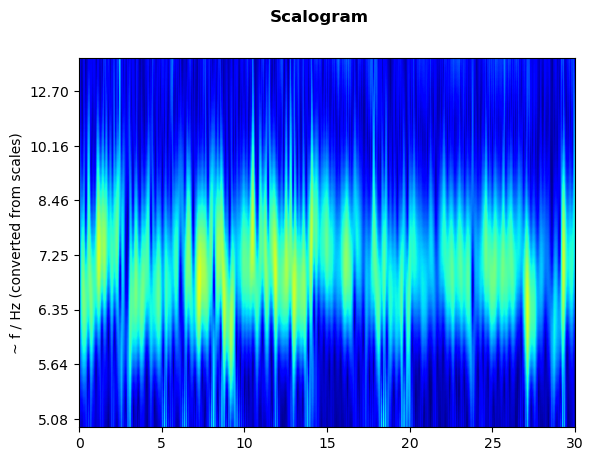

In [29]:
fig, ax = plt.subplots(1,1)
ax.imshow(np.abs(Wx), aspect='auto', extent=[0,30,s1,s0], cmap='jet')
yticks = ax.get_yticks()
ax.set(yticklabels=map(lambda x:'%.2f'%x,(convert(yticks)*fs)), ylabel='~ f / Hz (converted from scales)')
fig.suptitle('Scalogram', weight='bold')
plt.show()

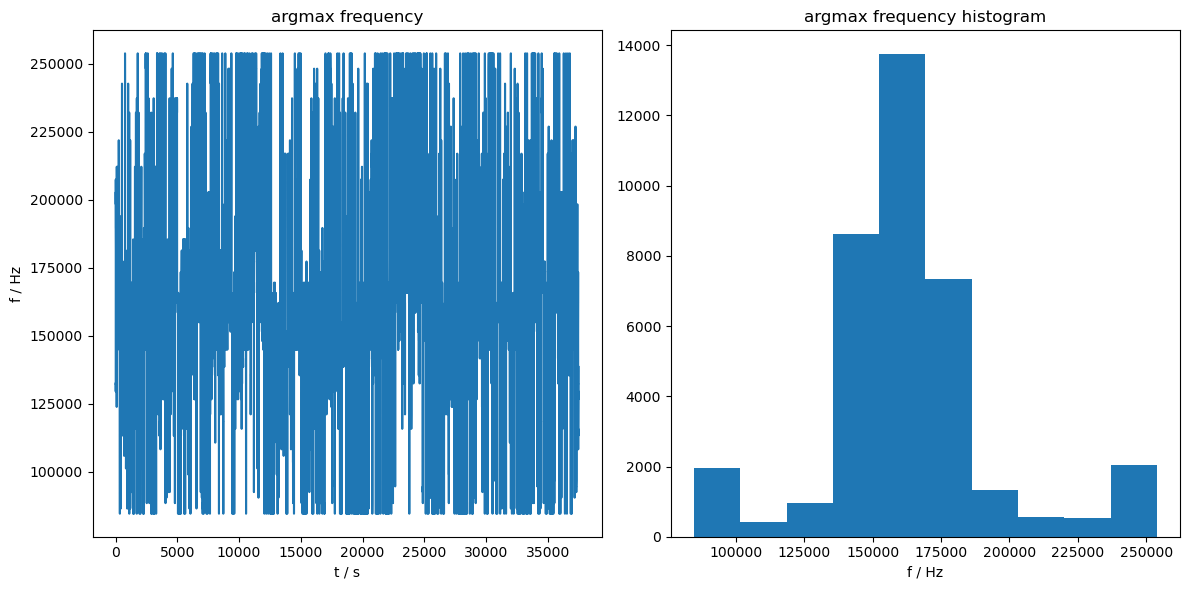

In [30]:
fig, ax = plt.subplots(1,2,figsize=(12,6))
f_argmax_cwt = convert(scales[np.argmax(np.abs(Wx), axis=0)])*fs
ax[0].plot(f_argmax_cwt)
ax[0].set(xlabel='t / s', ylabel='f / Hz', title='argmax frequency')
ax[1].hist(f_argmax_cwt)
ax[1].set(xlabel='f / Hz', title='argmax frequency histogram')
plt.tight_layout()
plt.show()

## Hilbert transform

Bandpass filter [5, 20] Hz

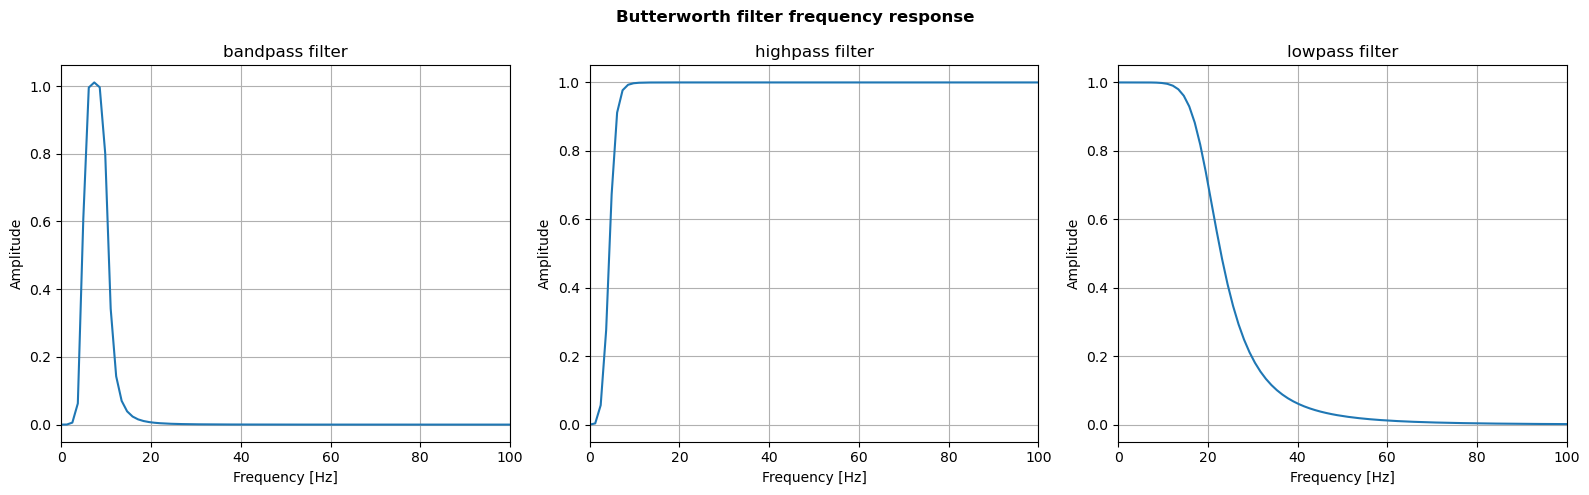

In [31]:
b, a = {}, {}
Wn = {'band':[5, 10], 'high':5, 'low':20}

for filt in Wn:
    b[filt], a[filt] = signal.butter(4, Wn=Wn[filt], btype=filt, fs=fs)

fig, ax = plt.subplots(1,3,figsize=(16,5))
for i, filt in enumerate(b.keys()):
    w, h = signal.freqz(b[filt], a[filt])
    ax[i].plot(fs*w/np.pi/2, (abs(h)))
    ax[i].set(title =filt+'pass filter', xlabel='Frequency [Hz]',
    ylabel='Amplitude', xlim=[0,100])
    ax[i].grid(which='both', axis='both')
    # ax[i].axvline(100, color='green') # cutoff frequency

fig.suptitle('Butterworth filter frequency response', weight='bold')
plt.tight_layout()
plt.show()

In [32]:
x_filt = {}
x_none = x
for filt in b:
    x_filt[filt] = signal.filtfilt(b[filt], a[filt], x_none)

x_filt['None'] = x_none

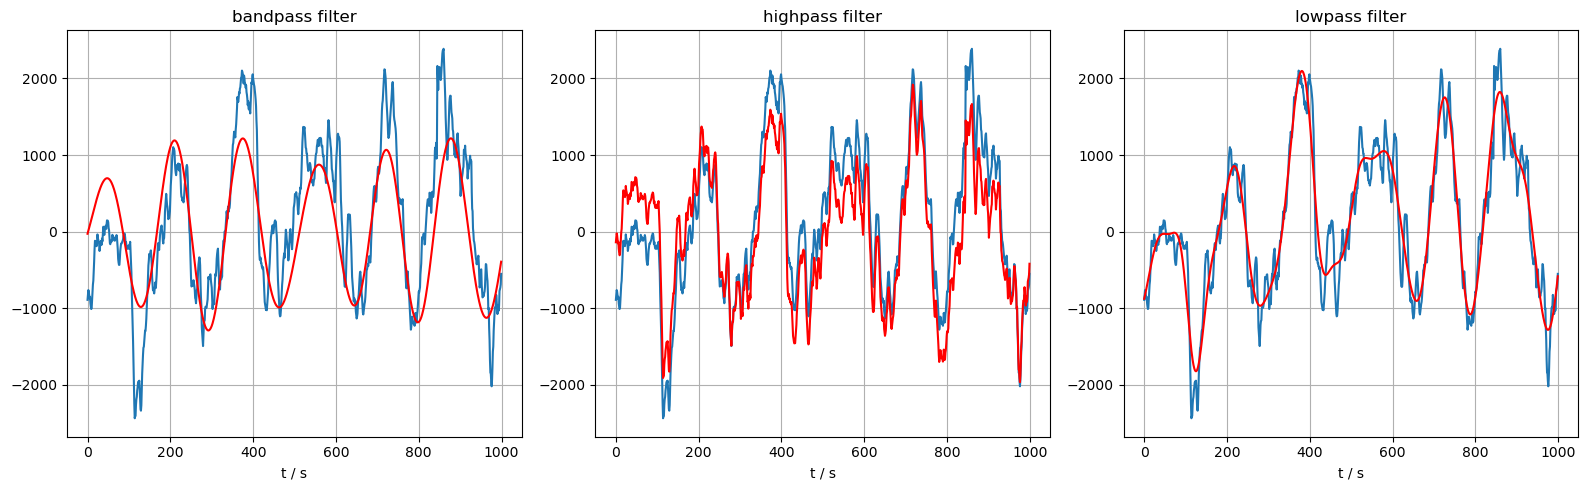

In [33]:
fig, ax = plt.subplots(1,3,figsize=(16,5))
for i, filt in enumerate(b.keys()):
    w, h = signal.freqz(b[filt], a[filt])
    ax[i].plot(x_none[:1000])
    ax[i].plot(x_filt[filt][:1000], 'r')
    ax[i].set(title =(filt + 'pass filter'), xlabel='t / s')
    ax[i].grid(which='both', axis='both')
    # ax[i].axvline(100, color='green') # cutoff frequency

plt.tight_layout()
plt.show()


In [34]:
def hilbert(x, fs=1, axis=0):
    """
    Use the Hilbert transform/ analytic signal to extract the instantaneous phase, frequency, and amplitude of
    a signal.

    Parameters
    ----------
    x : ndarray
        time-series data
    fs : float (default = 1)
        sampling frequency (Hz)
    axis : int (default=0)
        axis of x along which to compute the analytic signal
        
    Returns
    -------
    phase, frequency, amplitude : ndarray x 3
        arrays of instantaneous phase (in range -pi to pi), frequency, and amplitude
    """
    y = signal.hilbert(x, axis=axis) # complex analytic signal
    phase = np.angle(y) # CCW angle from positive real axis
    # rate of change of phase
    freq = np.gradient(np.unwrap(phase), axis=axis) / (2*np.pi) * fs
    amp = np.abs(y) # length of signal vector at each timepoint
    return phase, freq, amp

In [35]:
phase, freq, amp = [{} for i in range(3)]
for filt in x_filt.keys():
    phase[filt], freq[filt], amp[filt] = hilbert(x_filt[filt], fs=fs)

time = np.arange(len(x_none))/fs

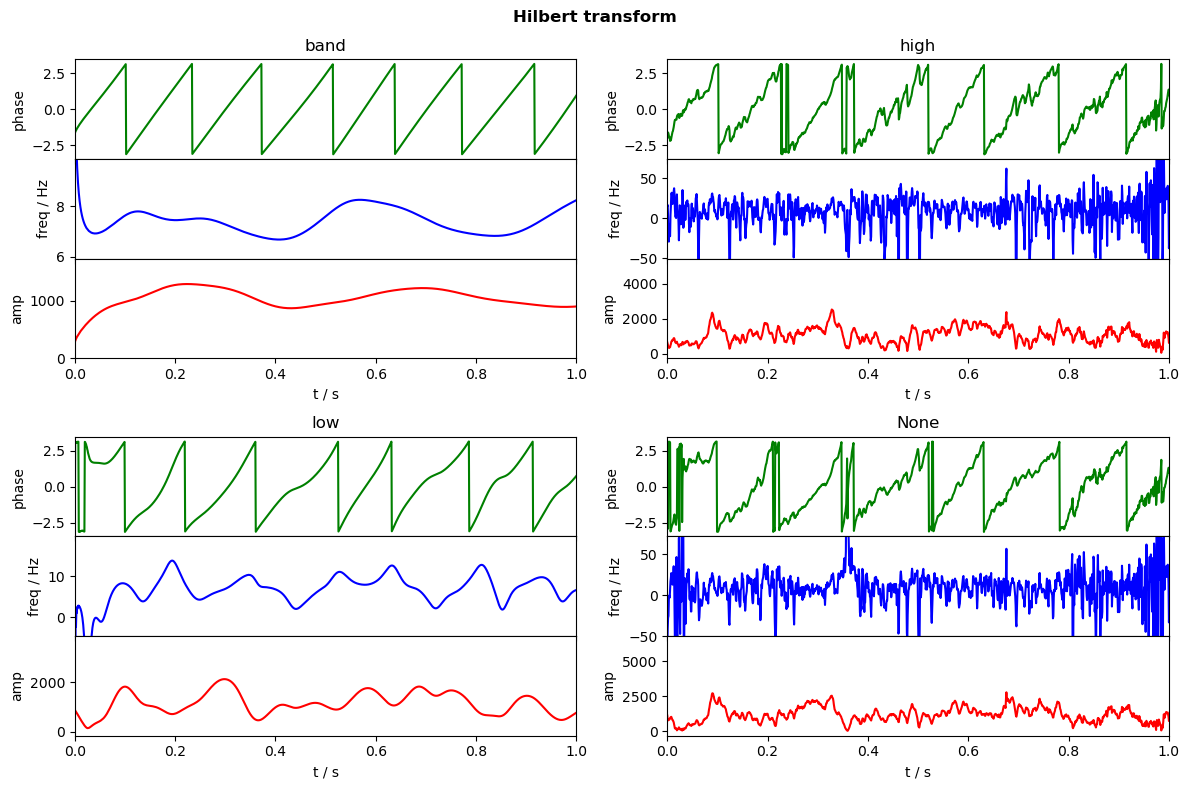

In [36]:
fig = plt.figure(figsize=(12,8))
gs0 = gridspec.GridSpec(2,2, figure=fig)

for i, filt in enumerate(x_filt.keys()):
    r = i//2
    c = i%2
    gs00 = gridspec.GridSpecFromSubplotSpec(3, 1, subplot_spec=gs0[r, c], hspace=0)
    t0 = 0
    t1 = 1
    ax0 = fig.add_subplot(gs00[0])
    ax1 = fig.add_subplot(gs00[1])
    ax2 = fig.add_subplot(gs00[2])

    ax0.plot(time, phase[filt], 'g')
    ax0.set(xlabel='t / s', ylabel='phase', xlim=[t0, t1], title=filt)
    plt.setp(ax0.get_xticklabels(), visible=False)

    ax1.plot(time, freq[filt], 'b')
    f0, f1 = np.array([-2,2])*np.std(freq[filt]) + np.mean(freq[filt])
    ax1.set(xlabel='t / s', ylabel='freq / Hz', xlim=[t0, t1], ylim=[f0, f1])
    plt.setp(ax1.get_xticklabels(), visible=False)
    plt.subplots_adjust(hspace=0)

    ax2.plot(time, amp[filt], 'r')
    ax2.set(xlabel='t / s', ylabel='amp', xlim=[t0, t1])
    # ax.legend()

    fig.suptitle('Hilbert transform', weight='bold')

plt.tight_layout()
plt.show()

In [37]:
def izscore(x, z, axis=-1):
    mu = np.mean(x, axis=axis) 
    std = np.std(x, axis=axis)
    return mu - z * std, mu + z * std 

In [38]:
def remove_outliers(x, z, axis=-1):
    x1, x2 = izscore(x, z, axis)
    return x[np.where((x1<x) & (x>x2))]

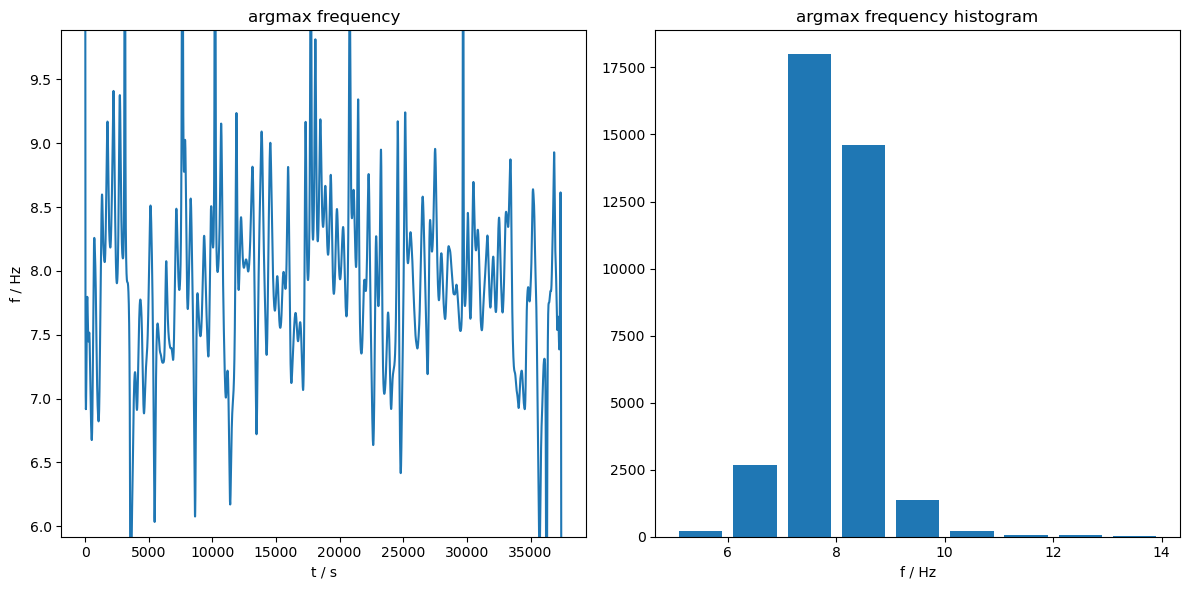

In [39]:
fig, ax = plt.subplots(1,2,figsize=(12,6))
f_argmax_hilbert = freq['band']
fzn2, fzp2 = izscore(f_argmax_hilbert, 2)
# f_argmax_hilbert_remove_outliers = remove_outliers(f_argmax_hilbert)
ax[0].plot(f_argmax_hilbert)
ax[0].set(xlabel='t / s', ylabel='f / Hz', title='argmax frequency', ylim=[fzn2, fzp2])
f_hil_hist, edges = np.histogram(f_argmax_hilbert, bins=np.arange(5, 15))
bins = edges[:-1] + np.diff(edges[:2])/2
ax[1].bar(bins, f_hil_hist)
ax[1].set(xlabel='f / Hz', title='argmax frequency histogram')
plt.tight_layout()
plt.show()

## Estimates of Theta frequency

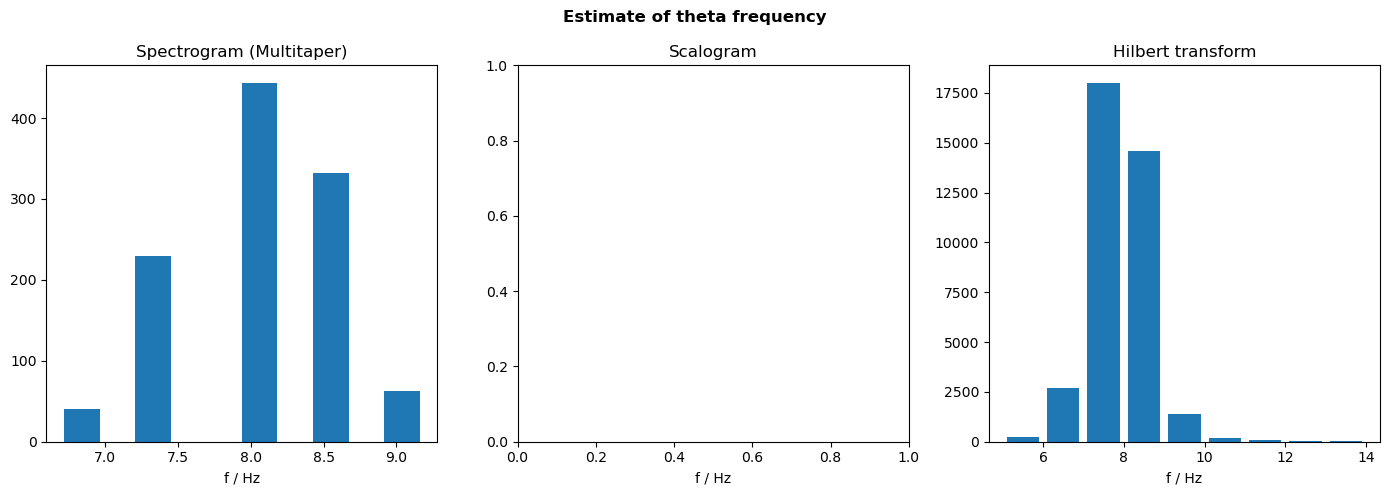

In [40]:
fig, ax = plt.subplots(1,3,figsize=(14,5))
ax[0].hist(f_argmax_spec)
ax[0].set(xlabel='f / Hz', title='Spectrogram (Multitaper)')
# ax[1].hist(f_argmax_cwt)
ax[1].set(xlabel='f / Hz', title='Scalogram')
ax[2].bar(bins, f_hil_hist)
ax[2].set(xlabel='f / Hz', title='Hilbert transform')
fig.suptitle('Estimate of theta frequency', weight='bold')
plt.tight_layout()
plt.show()

# Autoregressive Model

In [42]:
data96 = io.loadmat('../data/data96.mat')
print(data96.keys())
data96_lfp = data96['lfp'].astype(np.int32)

fs = 1250 # sampling frequency
dt = 1/fs
T = 30
N_total = T * fs
time_vec = np.arange(Nt)*dt

dict_keys(['__header__', '__version__', '__globals__', 'Channels', 'anatCurves', 'chanLoc', 'lfp', 'par'])


In [44]:
from statsmodels.tsa import ar_model
data96_lfp 
data96_zlfp = zscore(data96_lfp, axis=None) - np.mean(data96_lfp, axis=0)
x = data96_zlfp[:, 0]

In [45]:
win_size = 2**11
step = 2**5
# NWdf = 1 # half bandwidht in Hz
# NW = NWdf * win_size / fs
NW = 2.5
method = lambda x:np.mean(multitaper_psd(x, NW)[0], axis=0)
x_spec, t_spec = spectrogram(x, win_size=win_size, step=step, method=method, progress_report=True)

In [47]:
p = 5
ar_result = ar_model.AutoReg(x, lags=p).fit()
AR_filt = np.concatenate(([1], -ar_result.params))
x_white = np.convolve(AR_filt, x)

In [48]:
xw_spec, tw_spec = spectrogram(x_white, win_size=win_size, step=step, method=method, progress_report=True)

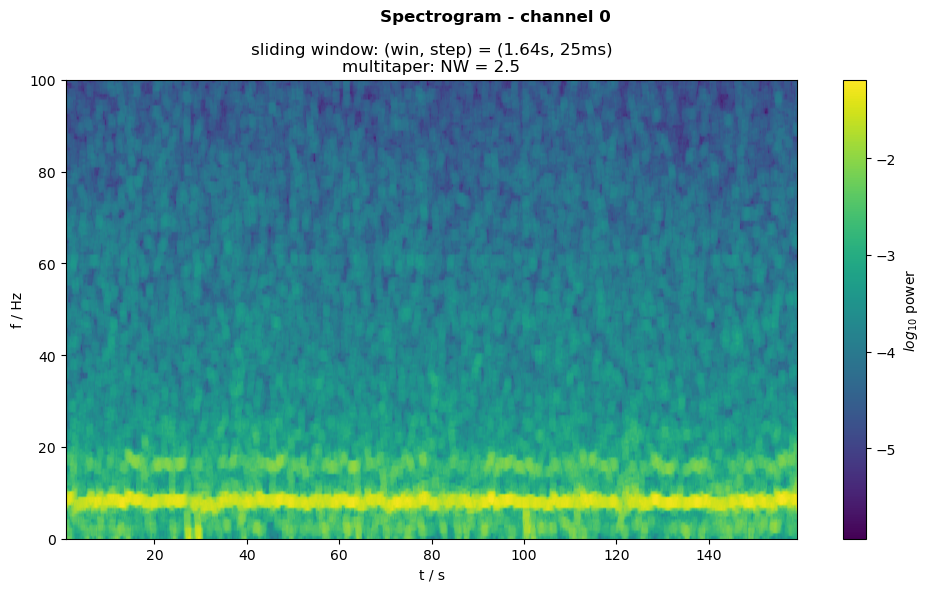

In [49]:
ichannel = 0
f_max = int(100/fs * win_size)
fig = plt.figure(figsize=(10,6))
ax = plt.subplot(1,1,1)
im = ax.imshow(np.log10(x_spec[:f_max, :]), aspect='auto', extent=[t_spec[0]/fs, t_spec[-1]/fs, 100, 0])
ax.set_xlabel('t / s')
ax.set_ylabel('f / Hz')
ax.invert_yaxis()
ax.set_title('sliding window: (win, step) = (%.2f'%(win_size/fs) +'s, %d'%(1000*step/fs) +'ms)\n''multitaper: NW = %.1f'%NW)
fig.colorbar(im, label='$log_{10}$ power')
fig.suptitle('Spectrogram - channel %d'%ichannel, weight='bold')
plt.tight_layout()
plt.show()

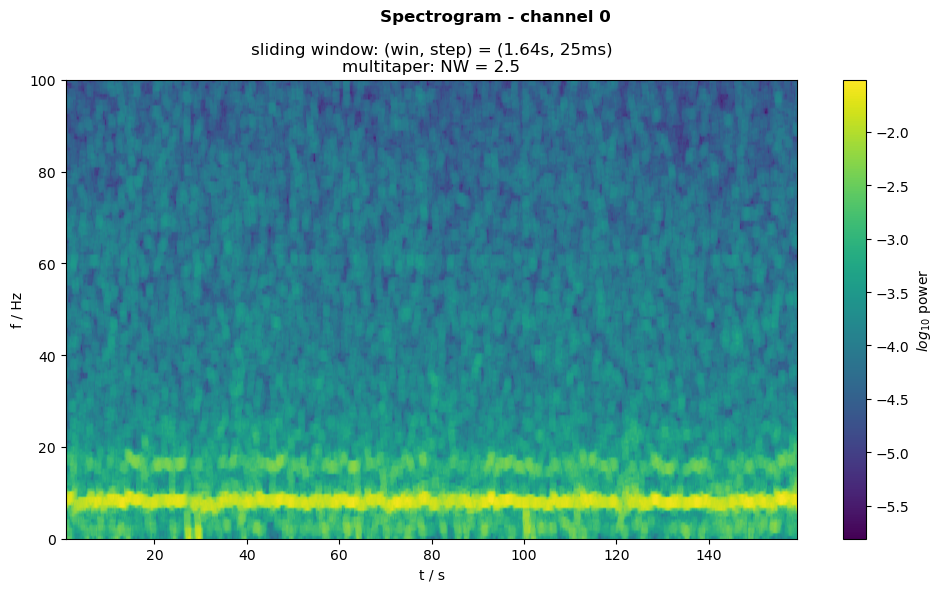

In [50]:
ichannel = 0
f_max = int(100/fs * win_size)
fig = plt.figure(figsize=(10,6))
ax = plt.subplot(1,1,1)
im = ax.imshow(np.log10(xw_spec[:f_max, :]), aspect='auto', extent=[t_spec[0]/fs, t_spec[-1]/fs, 100, 0])
ax.set_xlabel('t / s')
ax.set_ylabel('f / Hz')
ax.invert_yaxis()
ax.set_title('sliding window: (win, step) = (%.2f'%(win_size/fs) +'s, %d'%(1000*step/fs) +'ms)\n''multitaper: NW = %.1f'%NW)
fig.colorbar(im, label='$log_{10}$ power')
fig.suptitle('Spectrogram - channel %d'%ichannel, weight='bold')
plt.tight_layout()
plt.show()

In [53]:
rxx = np.convolve(x, x[::-1], mode='full')[len(x):]/(np.arange(1, len(x)))

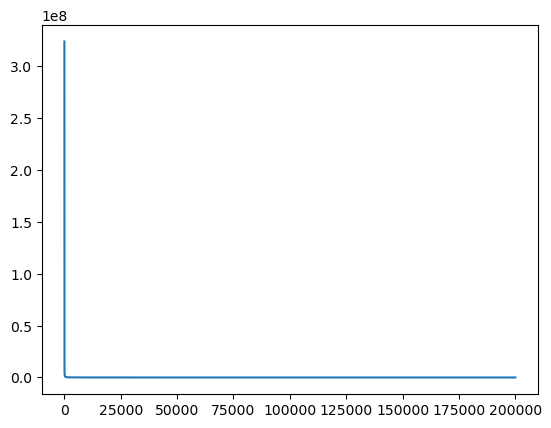

In [54]:
plt.plot(rxx)
# plt.ylim([-1, 1])

In [56]:
def autocovariance(X, p):
    '''
    calculate autocovariance for some data X
    p: time lag
    '''
    scale = len(X) - p
    autoCov = 0
    for i in np.arange(0, len(X)-p):
        autoCov += ((X[i+p]))*(X[i])
        
    return autoCov/scale - np.mean(X)**2

def AR_yule(p, X):
    '''
    estimate AR(p) coefficients a for data X by solving the Yule-
    Walker equation in matrix form
    
    p: order of AR model
    '''
    # x = zscore(X)
    # rxx = np.convolve(x, x[::-1], mode='full')[:len(x)-1][::-1][:p+1]/(np.arange(len(x)-p-1, len(x))[::-1])
    rxx = [autocovariance(X, i) for i in range(p+1)]

    Rxx_mat = np.zeros((p, p))
    for i in range(p):
        for j in range(i, p):
            Rxx_mat[i, j] = rxx[j-i]
            Rxx_mat[j, i] = Rxx_mat[i, j]

    a = np.linalg.inv(Rxx_mat) @ rxx[1:]

    return a


In [57]:
# whitening
def autocovariance(X, p):
    '''
    calculate autocovariance for some data X
    p: time lag
    '''
    scale = len(X) - p
    autoCov = 0
    for i in np.arange(0, len(X)-p):
        autoCov += ((X[i-p]))*(X[i])
        
    return autoCov/scale
    

def stack_cov(X, p):
    '''
    return a autocovariance matrix based on the Yule-Walker equation
    from data X of order p
    '''
    
    Xt_out = []
    cov = [autocovariance(X, i) for i in range(p)]
    cov_reverse = [autocovariance(X, p-i-1) for i in range(p)]
    
    for i in range(p):
        left = cov_reverse[:i]
        right = cov[:p-i]
        Xt_out.extend(left)
        Xt_out.extend(right)
        
    return np.array(Xt_out).reshape(p, p)


def AR(p, X):
    '''
    estimate AR(p) coefficients a for data X by solving the Yule-
    Walker equation in matrix form
    
    p: order of AR model
    '''
    
    X_mat = stack_cov(X, p)
    
    Y = [autocovariance(X, i) for i in range(1, p+1)]
    inv_XX = np.linalg.inv(np.dot(X_mat.T, X_mat))
    XY = np.dot(X_mat, Y)
    a = np.dot(inv_XX, XY)
    
    return a


def predict(a, X):
    '''
    estimate signal with AR coefficients a for data X
    '''
    
    Xt_out = []
    
    for t in range(len(a), len(X)):
        
        temp = 0
        
        for k in range(len(a)):
            temp += a[k]*X[t-k]
        
        Xt_out.append(temp)
        
    return Xt_out

def sigma2(a, x0, x_prev):
    '''
    calculate sigma^2 from Yule-Walker equation
    x0: data at t = 0 from AR estimated signal
    x_prev: data at t = 0-p to t = 0-1 from original signal
    return the noise/innovation/error term at t = 0
    '''
    
    p = len(a)
    variance = 0
    for i, a_i in enumerate(a):
        variance += a_i * x_prev[len(x_prev)-i-1]
    
    sigma = x0 - variance
    
    return sigma

def whiten_signal(signal, ar_order = 2):
    ar_coeffs = AR(ar_order, signal)
    ar_pred = predict(ar_coeffs, signal)
    return [sigma2(ar_coeffs, ar_pred[i], signal[i-ar_order:i]) for i in range(ar_order, len(ar_pred))]

<AxesSubplot:xlabel='Lag', ylabel='Autocorrelation'>

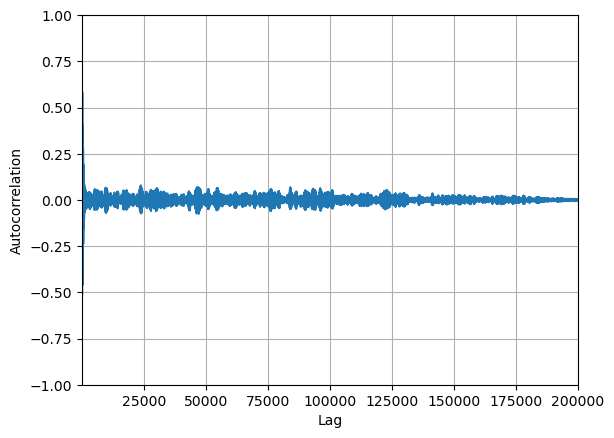

In [59]:
from pandas.plotting import autocorrelation_plot
autocorrelation_plot(x)

In [60]:
# whitening
def autocorrelation(X, p):
    '''
    calculate autocovariance for some data X
    p: time lag
    '''
    scale = len(X) - p
    autoCorr = 0
    for i in np.arange(0, len(X)-p):
        autoCorr += ((X[i-p]))*(X[i])
        
    return autoCorr/scale

def AR(p, X):
    '''
    estimate AR(p) coefficients a for data X by solving the Yule-
    Walker equation in matrix form
    
    p: order of AR model
    '''
    
    rxx = [autocorrelation(X, i) for i in range(0, p+1)]

    Rxx_mat = np.zeros((p, p))
    for i in range(p):
        for j in range(i, p):
            Rxx_mat[i, j] = rxx[j-i]
            Rxx_mat[j, i] = Rxx_mat[i, j]

    inv_XX = np.linalg.inv(np.dot(Rxx_mat.T, Rxx_mat))
    XY = np.dot(Rxx_mat, rxx)
    a = np.dot(inv_XX, XY)
    
    return a


def predict(a, X):
    '''
    estimate signal with AR coefficients a for data X
    '''
    
    Xt_out = []
    
    for t in range(len(a), len(X)):
        
        temp = 0
        
        for k in range(len(a)):
            temp += a[k]*X[t-k]
        
        Xt_out.append(temp)
        
    return Xt_out

def sigma2(a, x0, x_prev):
    '''
    calculate sigma^2 from Yule-Walker equation
    x0: data at t = 0 from AR estimated signal
    x_prev: data at t = 0-p to t = 0-1 from original signal
    return the noise/innovation/error term at t = 0
    '''
    
    p = len(a)
    variance = 0
    for i, a_i in enumerate(a):
        variance += a_i * x_prev[len(x_prev)-i-1]
    
    sigma = x0 - variance
    
    return sigma

def whiten_signal(signal):
    ar_order = 2
    ar_coeffs = AR(ar_order, signal)
    ar_pred = predict(ar_coeffs, signal)
    return [sigma2(ar_coeffs, ar_pred[i], signal[i:i+ar_order]) for i in range(len(ar_pred))]

In [61]:
x_white = whiten_signal(x)

ValueError: shapes (2,2) and (3,) not aligned: 2 (dim 1) != 3 (dim 0)